<a href="https://colab.research.google.com/github/rahiakela/transfer-learning-for-natural-language-processing/blob/main/2-getting-started-with-baselines/2_linear_and_tree_based_models_for_movie_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear & Tree-based models for Movie Sentiment Classification

Our goal is to establish a set of baselines for a pair of concrete NLP problems, which we will later be able to use to measure progressive improvements gained from leveraging increasingly sophisticated transfer learning
approaches. In the process of doing this, we aim to advance your general NLP instincts and refresh your understanding of typical procedures involved in setting up problem-solving pipelines for such problems. You will review techniques ranging from tokenization to data structure and model selection. We first train some traditional machine learning models from scratch to establish some preliminary baselines for these problems.

We will focus on a pair of important representative example NLP problems – spam
classification of email, and sentiment classification of movie reviews. This exercise will arm you with a number of important skills, including some tips for obtaining, visualizing and preprocessing data. 

Three major model classes will be covered, namely linear models such as logistic regression, decision-tree-based models such as random forests, and neural-network-based models such as ELMo. These classes are additionally represented by support vector machines (SVMs) with linear kernels, gradient-boosting machines (GBMs) and BERT respectively. 

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/content-classification-supervised-models.png?raw=1' width='800'/>



## Setup

In [1]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import email        # email package for processing email messages
import random
import re
import os
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC                              # Support Vector Classification model
from sklearn.ensemble import RandomForestClassifier      # random forest classifier library
from sklearn.ensemble import GradientBoostingClassifier  # GBM algorithm

from sklearn.model_selection import GridSearchCV, cross_val_score         # for tune parameters systematically
from sklearn import metrics                              #Additional scklearn functions
from sklearn.metrics import accuracy_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%%shell

wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
tar xzf aclImdb_v1.tar.gz

rm -rf aclImdb_v1.tar.gz
rm -rf aclImdb/train/unsup

## Preprocessing Movie Sentiment Classification Example Data

This notebook is concerned with classifying movie reviews from IMDB into
positive or negative sentiments expressed. This is a prototypical sentiment analysis example that has been used widely in the literature to study many algorithms.

We will use a popular labeled dataset of 25000 reviews for this, which was assembled by scraping the popular movie review website IMDB and mapping the number of stars corresponding to each review to either 0 or 1 – depending on whether it was less than or greater than 5 out of 10 stars respectively.It has been used widely in prior NLP literature, and this familiarity is part of the reason we choose it as an illustrative example for baselining.

The sequence of steps used to preprocess each IMDB movie review before analysis is very similar to the one presented for the email spam classification example.

The first major difference is that no email headers are attached to these reviews, so the header extraction step is not applicable. 

Additionally, since some stopwords – including “no” and “not” – may
change the sentiment of the message, the stopword removal step may need to be carried out with extra care, first making sure to drop such stopwords from the target list. We did experiment with dropping such words from the list, and saw little to no effect on the result. This is likely because other non-stopwords in the reviews are very predictive features, rendering this step irrelevant.

<img src='https://github.com/rahiakela/img-repo/blob/master/transfer-learning-for-natural-language-processing/spam-email-preprocessing.png?raw=1' width='800'/>


### IMDB Movie Review Dataset preprocessing

Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters.

In [3]:
n_sample = 1000   # number of samples to generate in each class
maxtokens = 50    # the maximum number of tokens per document
maxtokenlen = 20  # the maximum length of each token

With these hyperparameters specified, we can now create a single DataFrame for the overarching training dataset. Let’s take the opportunity to also perform remaining preprocessing tasks, namely removing stop words, punctuations and tokenizing.

#### Tokenization

Let’s proceed by defining a function to tokenize text by splitting them into 
words.

In [4]:
def tokenize(row):
  if row is None or row is "":
    tokens = ""
  else:
    tokens = row.split(" ")[:maxtokens]
  return tokens

#### Remove punctuation and unnecessary characters

**In order to ensure that classification is done based on language content only, we have to remove punctuation marks and other non-word characters from the emails.** We do this by employing regular expressions with the Python regex library. We also normalize words by turning them into lower case.

In [5]:
def reg_expressions(row):
  tokens = []
  try:
    for token in row:
      token = token.lower()          # make all characters lower case
      token = re.sub(r"[\W\d]", "", token)
      token = token[:maxtokenlen]    # truncate all tokens to hyperparameter maxtokenlen
      tokens.append(token)
  except:
    token = ""
    tokens.append(token)
  return tokens

#### Stop-word removal

Stop-words are also removed. Stop-words are words that are very common in text but offer no useful information that can be used to classify the text. Words such as is, and, the, are are examples of stop-words. The NLTK library contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [6]:
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning of a sentence
stop_words.remove("no")
stop_words.remove("nor")
stop_words.remove("not")

In [8]:
def stop_word_removal(row):
  token = [token for token in row if token not in stop_words]
  token = filter(None, token)

  return token

### Converting the Sentiment Text Into Numbers

We start by employing what is often considered the simplest method for vectorizing words, i.e., converting them into numerical vectors – the bag-of-words model. This model simply counts the frequency of word tokens contained in each email and thereby represents it as a vector of such frequency counts.

Please observe that in doing this, we only retain tokens that appear more than once, as captured by the variable “used_tokens”. This enables us to keep the vector dimensions significantly lower than they would be otherwise. Please also
note that one can achieve this using various in-built vectorizers in the popular library scikitlearn.

We also note the scikit-learn vectorization methods include counting occurrences of sequences of any n words, or n-grams, as well as the tf-idf approach – important fundamental concepts you should brush on if rusty. For the problems looked at here, we did not notice an improvement when using these vectorization methods over the bag-of words approach.

For the computer to make inferences of the sentiment, it has to be able to interpret the text by making a numerical representation of it. One way to do this is by using something called a "bag-of-words" model. This model simply counts the frequency of word tokens for each sentiment and thereby represents it as a vector of these counts.

The assemble_bag() function assembles a new dataframe containing all the unique words found in the text documents. It counts the word frequency and then returns the new dataframe.

In [9]:
def assemble_bag(data):
  used_tokens = []
  all_tokens = []

  for item in data:
    for token in item:
      if token in all_tokens:
        # If token has been seen before, append it to output list used_tokens
        if token not in used_tokens:
          used_tokens.append(token)
      else:
        all_tokens.append(token)

  df = pd.DataFrame(0, index=np.arange(len(data)), columns=used_tokens)

  # Create a Pandas DataFrame counting frequencies of vocabulary words – corresponding to columns, in each email – corresponding to rows
  for i, item in enumerate(data):
    for token in item:
      if token in used_tokens:
        df.iloc[i][token] += 1

  return df

Having fully vectorized the dataset, we must remember that it is not shuffled with respect to classes, i.e., it contains Nsamp = 1000 spam emails followed by an equal number of nonspam emails. Depending on how this dataset is split, in our case by picking the first 70% for training and the remainder for testing, this could lead to a training set composed of spam only, which would obviously lead to failure. In order to create a randomized ordering of class samples in the dataset, we will need to shuffle the data in unison with the header/list of labels.

In [10]:
# shuffle raw data first
def unison_shuffle_data(data, header):
  p = np.random.permutation(len(header))
  data = data[p]
  header = np.asarray(header)[p]

  return data, header

Let's load dataset into a Numpy array after tokenizing, removing stopwords and punctuations, and shuffling.

In [11]:
# load data in appropriate form
def load_data(path):
  data, sentiments = [], []
  for folder, sentiment in (("neg", 0), ("pos", 1)):
    folder = os.path.join(path, folder)
    for name in os.listdir(folder):
      with open(os.path.join(folder, name), "r") as reader:
        text = reader.read()
      text = tokenize(text)            # tokenizing
      text = stop_word_removal(text)   # removing stopwords and punctuations
      text = reg_expressions(text)
      data.append(text)
      sentiments.append(sentiment)     # Track corresponding sentiment labels

  # converting to Numpy array
  data_np = np.array(data)
  # shuffling
  data, sentiments = unison_shuffle_data(data_np, sentiments)

  return data, sentiments

In [12]:
train_path = os.path.join("aclImdb", "train")
test_path = os.path.join("aclImdb", "test")

raw_data, raw_header = load_data(train_path)
print(raw_data.shape)
print(len(raw_header))

(25000,)
25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


Let's take n_sample*2 random entries of the loaded data for training:

In [13]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header)), size=(n_sample * 2, ), replace=False)
data_train = raw_data[random_indices]
header = raw_header[random_indices]

print("DEBUG::data_train::")
print(data_train[:5])

DEBUG::data_train::
[list(['according', 'imdb', 'well', 'every', 'website', 'holds', 'review', 'thing', 'director', 'well', 'would', 'surely', 'explain', 'lot', 'just', 'bunch', 'people', 'gathered', 'together', 'shoot', 'perverted', 'porn', 'sequences', 'throw', 'ultrathin', 'storyline', 'devilworshiping'])
 list(['no', 'redeeming', 'features', 'film', 'rubbish', 'its', 'jokes', 'begin', 'funny', 'the', 'humour', 'children', 'pathetic', 'attempts', 'appeal', 'adults', 'add', 'tacky', 'smuttishness', 'whole', 'miserable', 'package', 'sitting', 'children', 'made', 'uncomfortable', 'might'])
 list(['im', 'not', 'going', 'bother', 'plot', 'synopsis', 'since', 'know', 'movie', 'theres', 'almost', 'no', 'plot', 'anyway', 'ive', 'seen', 'several', 'reviewers', 'call', 'isoyg', 'antirape', 'film', 'even', 'feminist', 'statement', 'i', 'chime', 'galling', 'hypocrisy'])
 list(['with', 'title', 'like', 'attack', 'killer', 'tomatoes', 'anyone', 'going', 'thing', 'would', 'expecting', 'either', 'a

Before proceeding, we need to check the balance of the resulting data with regards to class. In general, we don’t want one of the labels to represent most of the dataset, unless that is the distribution expected in practice.

In [14]:
# Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[1012  988]


We are now ready to convert these into numerical vectors!!

Having satisfied ourselves that the data is roughly balanced between the two classes, with each class representing roughly half of the dataset, assemble and visualize the bag-of-words representation.

In [15]:
# create bag-of-words model
mixed_bag_reviews  = assemble_bag(data_train) 

# this is the list of words in our bag-of-words model
predictors = [column for column in mixed_bag_reviews.columns]

# expand default pandas display options to make emails more clearly visible when printed
pd.set_option("display.max_colwidth", 300)

mixed_bag_reviews

,well,children,no,plot,film,going,thing,would,movie,bad,science,fiction,its,i,show,not,the,one,best,seen,people,like,how,br,question,movies,,plays,expectations,low,watching,it,comedy,first,this,you,could,every,much,explain,...,ogling,protagonists,reflecting,relatively,forgettable,covering,geography,thousands,scope,continually,emergency,fog,eerie,moody,texture,castbr,akshay,abraham,futurebr,kumar,demeaning,ruby,comingofage,ashley,judd,suicide,press,carter,souls,myth,newer,recycled,balls,mom,dollars,technicolor,religion,ordeal,owner,birds
0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,1,1,2,2,2,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,3,2,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1998,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


With this numerical representation ready, we now proceed to building out our baseline classifiers in the subsequent sections for the two presented example datasets.

As the very last step of preparing the sentiment dataset for training by our baseline classifiers, we split it into independent training and testing or validation sets. This will allow us to evaluate the performance of the classifier on a set of data that was not used for training, an important thing
to ensure in machine learning practice. We elect to use 70% of the data for training, and 30% for testing/validation afterwards.

In [16]:
# split into independent 70% training and 30% testing sets
data = mixed_bag_reviews.values

idx = int(0.7 * data.shape[0])  # get 70% index value

# 70% of data for training
train_x = data[:idx, :]
train_y = header[:idx]

# remaining 30% for testing
test_x = data[idx:, :]
test_y = header[idx:]

print("train_x/train_y list details, to make sure they are of the right form:")
print(len(train_x))
print(train_x)
print(len(train_y))
print(train_y[:5])

train_x/train_y list details, to make sure they are of the right form:
1400
[[2 0 0 ... 0 0 0]
 [0 2 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1400
[0 0 0 0 1]


Since 70% of 2000 is 1400, looks good! (for n_sample=1000)

### How about other vectorization strategies?

Let's check some other vectorization strategies.

In [17]:
# create the transform - uncomment the one you want to focus on
# vectorizer = CountVectorizer()    # this is equivalent to the bag of words
vectorizer = TfidfVectorizer()    # tf-idf vectorizer
# vectorizer = HashingVectorizer(n_features=3000)  # hashing vectorizer

In [18]:
# build vocabulary
vectorizer.fit([" ".join(sublist) for sublist in data_train])
# summarize
print(len(vectorizer.vocabulary_))
print(vectorizer.idf_)

# encode one document
vector = vectorizer.transform([" ".join(data_train[0])])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

# set this to 'True' if you want to use the vectorizer featurizers instead of the bag-of-words done before
USE = False
if USE:
  data = vectorizer.transform([" ".join(sublist) for sublist in data_train]).toarray()
  # 70% of data for training
  train_x = data[:idx, :]
  # remaining 30% for testing
  test_x = data[idx, :]

  print("train_x/train_y list details, to make sure it is of the right form:")
  print(train_x.shape[0])
  print(train_x)
  print(train_y[:5])
  print(len(train_y))
  predictors = [column for column in vectorizer.vocabulary_]

12313
[7.90825515 7.90825515 7.50279005 ... 7.21510797 7.90825515 7.90825515]
(1, 12313)
[[0. 0. 0. ... 0. 0. 0.]]


## Generalized Linear Models

Traditionally, the development of models in any area of applied mathematics has started with linear models. These models are mappings that preserve addition and multiplication in the input and output spaces. In other words, the net response from a pair of inputs will be the sum of the responses to each individual input. This property enables a significant reduction in associated
statistical and mathematical theory.

In this section, we will apply a pair of the most widely-used generalized linear machine learning algorithms to the pair of example problems that were introduced in the previous section– logistic regression and support vector machines (SVMs) with linear kernel. Other popular generalized linear machine learning models that will not be applied include the simple perceptron
neural architecture with a linear activation function, latent dirichlet allocation (LDA) and Naive Bayes.

### Logistic Regression

Logistic regression models the relationship between a categorical output variable and a set of input variables by estimating probabilities with the logistic function. Assuming the existence of a single input variables x, and a single output binary variable y with associated probability $P(y=1)=p$.

Now, let’s go ahead and build our classifier using the popular library scikit-learn.

In [19]:
def fit_model(train_x, train_y):
  model = LogisticRegression()  # Instantiate model

  try:
    model.fit(train_x, train_y)  # Fit model to prepared labeled data
  except:
    pass

  return model

Now let's fit this model to our data for IMDB classification example.

In [20]:
model = fit_model(train_x, train_y)

To evaluate performance, we must test on the “hold out” test/validation sets that were put together for each example.

In [21]:
predicted_labels = model.predict(test_x)

# print all labels for full trasparency
print("DEBUG::The logistic regression predicted labels are::")
print(predicted_labels)

DEBUG::The logistic regression predicted labels are::
[1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1
 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1
 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1
 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0
 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1
 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1
 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0
 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1

In [22]:
acc_score = accuracy_score(test_y, predicted_labels)

print("The logistic regression accuracy score is::")
print(acc_score)

The logistic regression accuracy score is::
0.6683333333333333


Before proceeding, it is important to address the use of accuracy as the metric for evaluating performance. Accuracy is defined as the ratio of correctly identified samples, i.e., the ratio of the number of true positives and negatives to the total number of samples. 

Other potential metrics that could be used here include precision – the ratio of the number of true positives to all predicted positives, and recall – the ratio of the number of true positives to all actual positives. These two measures could be useful if the costs of false positives and false negatives
(respectively) are particularly important. 

Crucially, the F1-score – the harmonic mean of precision and recall – strikes a balance between the two, and is particularly useful for imbalanced datasets. This is the most common situation in practice, making this metric very important.


### Support Vector Machine Classifier

SVMs has traditionally been the most popular kind of kernel method.
These methods attempt to find good decision boundaries by mapping data to a high dimensional space, using hyperplanes as decision boundaries and the kernel trick to reduce computing cost. When the kernel function is a linear function, SVMs are not only generalized linear models, but are indeed linear models.

Note that because this classifier takes a bit longer to train than the logistic regression one, we employ the inbuilt Python library time to determine the training time.

In [23]:
# Create a support vector classifier
clf = SVC(C=1, gamma="auto", kernel="linear", probability=False)

# Fit the classifier using the training data
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the SVC Classifier took %3d seconds" % (end_time - start_time))

# test and evaluate
predicted_labels = clf.predict(test_x)
print("DEBUG::The SVC Classifier predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("The SVC Classifier testing accuracy score is::")
print(acc_score)

Training the SVC Classifier took  14 seconds
DEBUG::The SVC Classifier predicted labels are::
[1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1
 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0
 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1
 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1
 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0
 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1
 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1
 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1
 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0
 0 1 1

Training the classifier on the IMDB data took 36 seconds and yielded an accuracy score of 0.656. We see that SVM significantly underperforms logistic regression for the email spam classification problem, while achieving lower but nearly comparable performance for the IMDB problem.

## Decision-Tree-Based Models

A decision tree is a decision support aid that models decisions and their consequences as trees - a graph where any two nodes are connected by exactly one path. An alternative definition of a tree is a flowchart transforming input values into output categories.

In this section, we apply two of the most commonly used kinds of decision-tree-based methods – Random Forests and Gradient Boosting Machines – to the two illustrative running example problems. Other popular decision-tree-based methodologies that will not be explored include bagging, bootstrapping and boosting.

### Random Forests (RFs)

Random Forests (RFs) provide a practical machine learning method for applying decision trees. It involves generating a very large number of specialized trees and ensembling their outputs. RFs are extremely flexible and widely applicable, making them often the second algorithm practitioners try after logistic regression for baselining.



In [24]:
clf = RandomForestClassifier(n_jobs=1, random_state=0)

# Train the Classifier to take the training features and learn how they relate to the training y (spam, not spam?)
start_time = time.time()
clf.fit(train_x, train_y)
end_time = time.time()
print("Training the Random Forest Classifier took %3d seconds" % (end_time - start_time))

predicted_labels = clf.predict(test_x)
print("DEBUG::The RF predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("DEBUG::The RF testing accuracy score is::")
print(acc_score)

Training the Random Forest Classifier took   2 seconds
DEBUG::The RF predicted labels are::
[1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1
 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0
 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0
 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1
 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0
 0 1 0 1

Training it on the IMDB example similarly took under a second and achieved an accuracy score of 0.658.

In [25]:
# Now, tune parameters systematically
print("Available hyper-parameters for systematic tuning available with RF:")
print(clf.get_params())

Available hyper-parameters for systematic tuning available with RF:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [26]:
# select a subset of parameters to tune, and specify grid for each
param_grid = {
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 6, 10],
    "n_estimators": [10, 100, 1000]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# Fit the grid search to the data
grid_search.fit(train_x, train_y)

print("Best parameters found:")
print(grid_search.best_params_)

print("Estimated accuracy is:")
acc_score = accuracy_score(test_y, grid_search.best_estimator_.predict(test_x))
print(acc_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  5.0min finished


Best parameters found:
{'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Estimated accuracy is:
0.6733333333333333


This further confirms the initial hunch from previous section that the IMDB review problem is harder than the email classification problem that was set up.

### Gradient Boosting Machines (GBMs)

This variant of decision-tree-based machine learning algorithms iteratively learns new decisiontree- based models that address weak points of models from the previous iterations. At the time of this writing, they are widely considered to be the best class of methods for addressing nonperceptual
ML problems. This does come with some disadvantages unfortunately, including
larger model size, higher risk of overfitting and less interpretability than some other decisiontree models.


In [29]:
def modelfit(alg, train_x, train_y, predictors, test_x, performCV=True, printFeatureImportance=False, cv_folds=5):
  # Fit the algorithm on the data
  alg.fit(train_x, train_y)

  # Predict training set:
  predictions = alg.predict(train_x)
  predprob = alg.predict_proba(train_x)[:, 1]

  # Perform cross-validation:
  if performCV:
    cv_score = cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring="roc_auc")

  # Print model report:
  print("\nModel Report")
  print("Accuracy : %.4g" % metrics.accuracy_score(train_y, predictions))
  print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, predprob))

  if performCV:
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

  # Print Feature Importance:
  if printFeatureImportance:
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp[:10].plot(kind="bar", title="Feature Importances")

  return alg.predict(test_x), alg.predict_proba(test_x)

In [30]:
gbm0 = GradientBoostingClassifier(random_state=10)

start_time = time.time()
test_predictions, test_probs = modelfit(gbm0, train_x, train_y, predictors, test_x)
end_time = time.time()
print("Training the Gradient Boosting Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = test_predictions
print("DEBUG::The Gradient Boosting predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("DEBUG::The Gradient Boosting testing accuracy score is::")
print(acc_score)


Model Report
Accuracy : 0.8593
AUC Score (Train): 0.943866
CV Score : Mean - 0.7208225 | Std - 0.03457634 | Min - 0.6594979 | Max - 0.752666
Training the Gradient Boosting Classifier took  64 seconds
DEBUG::The Gradient Boosting predicted labels are::
[1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1
 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0
 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0

We can see some evidence of overfitting, as the testing accuracy is lower than the k-fold training accuracy for the first example. Moreover, in the case of the IMDB example, the k-fold cross validation scores are noticeably lower than the training score on the overall dataset, underscoring the importance of using the k-fold cross-validation approach for tracking overfitting in this model type.

So what exactly is the ROC curve? The ROC curve is the plot of the false positive rate (FPR) versus the true positive rate (TPR). It is an important characteristic used to evaluate and tune classifiers. It shows the tradeoff in these important qualities of a classifier as the decision threshold, the probability value beyond which a predicted confidence begins to be classified as
a member of a given class, is varied between 0 and 1.

600


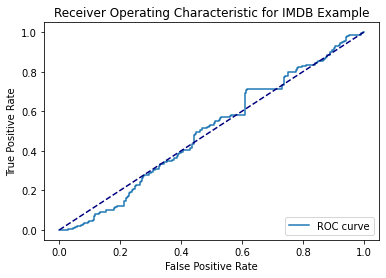

In [32]:
# Make an ROC curve

# first need to find probabilities corresponding to most likely class (max probability)
test_probs_max = []
for i in range(test_probs.shape[0]):
  test_probs_max.append(test_probs[i, test_y[i]])
print(len(test_probs_max))

# now, generate the curve data
fpr, tpr, thresholds = metrics.roc_curve(test_y, np.array(test_probs_max))

# plot curve data
fig,ax = plt.subplots()
plt.plot(fpr,tpr,label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for IMDB Example')
plt.legend(loc="lower right")
plt.show()

One important property of decision-tree-based methods is that they are able to provide an importance score for features, which can be used to detect the most important features in a given dataset.

In [35]:
def modelfit(alg, train_x, train_y, predictors, test_x, performCV=True, printFeatureImportance=True, cv_folds=5):
  # Fit the algorithm on the data
  alg.fit(train_x, train_y)

  # Predict training set:
  predictions = alg.predict(train_x)
  predprob = alg.predict_proba(train_x)[:, 1]

  # Perform cross-validation:
  if performCV:
    cv_score = cross_val_score(alg, train_x, train_y, cv=cv_folds, scoring="roc_auc")

  # Print model report:
  print("\nModel Report")
  print("Accuracy : %.4g" % metrics.accuracy_score(train_y, predictions))
  print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, predprob))

  if performCV:
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

  if printFeatureImportance:
    fig,ax = plt.subplots()

    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp[:10].plot(kind="bar", title="Feature Importances", ax=ax)

    plt.ylabel('Feature Importance Score')
    fig.savefig('GBMimportances.eps', format='eps',bbox_inches='tight')
    fig.savefig('GBMimportances.pdf', format='pdf',bbox_inches='tight')
    fig.savefig('GBMimportances.png', format='png',bbox_inches='tight')
    fig.savefig('GBMimportances.svg', format='svg',bbox_inches='tight')


  return alg.predict(test_x)


Model Report
Accuracy : 0.8593
AUC Score (Train): 0.943866
CV Score : Mean - 0.7208225 | Std - 0.03457634 | Min - 0.6594979 | Max - 0.752666
Training the Gradient Boosting Classifier took 112 seconds
DEBUG::The Gradient Boosting predicted labels are::
[1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1
 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1
 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0
 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0

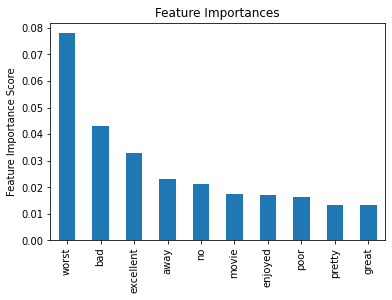

In [37]:
gbm = GradientBoostingClassifier(random_state=10)

start_time = time.time()
test_predictions = modelfit(gbm, train_x, train_y, predictors, test_x)
end_time = time.time()
print("Training the Gradient Boosting Classifier took %3d seconds"%(end_time-start_time))

predicted_labels = test_predictions
print("DEBUG::The Gradient Boosting predicted labels are::")
print(predicted_labels)

acc_score = accuracy_score(test_y, predicted_labels)
print("DEBUG::The Gradient Boosting testing accuracy score is::")
print(acc_score)

We see that words like “worst” and “awful” are very important to the classification decision, which makes qualitative sense, since one can imagine a negative critic using these words. On the other hard, words like “loved” may
be used by a positive critic.

It is important to caution you, however, that while these importance scores seem to work well for this example, they should not always be blindly trusted. For instance, it has been widely recognized that these importance scores can be biased towards continuous variables, as well as high cardinality categorical variables.


### XGBoost Model classifier